In [1]:
from __future__ import print_function
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import tables as tb
import numpy  as np

%matplotlib inline

nevts = 100000 #  Simulate nevts in 5, 10, and 15mm pitch maps
size = 210 #  size x size is size of active region in mm

In [2]:
# Old light paramaterization 
# Number of time bins
n_tbins = 2

# Coefficients from S2 parameterization
M = [1.599, 1.599]
c0 = [7.72708346764e-05, 0.000116782596518]
c1 = [-1.69330613273e-07, 3.05115354927e-06]
c2 = [-1.52173658255e-06, -7.00800605142e-06]
c3 = [-2.4985972302e-07, 6.53907883449e-07]
c4 = [1.12327204397e-07, 8.95230202525e-08]
c5 = [-1.49353264606e-08, -2.27173290582e-08]
c6 = [1.04614146487e-09, 2.00740799864e-09]
c7 = [-4.19111362353e-11, -9.21915945523e-11]
c8 = [9.12129133361e-13, 2.20534216312e-12]
c9 = [-8.40089561697e-15, -2.1795164563e-14]

# Maximum radial extent of parameterization
rmax = 20.

# Return the SiPM response for the specified time bin and radial distance.
def sipm_par(tbin,r):

    # Ensure the time bin value is valid.
    if(tbin < 0 or tbin >= n_tbins):
        print("Invalid time bin in sipm_param: returning 0.0 ...")
        return 0.0

    # Calculate the response based on the parametrization.
    vpar = M[tbin]*(c0[tbin] + c1[tbin]*r + c2[tbin]*r**2 + c3[tbin]*r**3 + 
    c4[tbin]*r**4 + c5[tbin]*r**5 + c6[tbin]*r**6 + c7[tbin]*r**7 + 
    c8[tbin]*r**8 + c9[tbin]*r**9)

    # Zero the response for radii too large.
    if(hasattr(vpar, "__len__")):
        ret = np.zeros(len(vpar)); iret = 0
        for rv,pv in zip(r,vpar):
            if(rv < rmax):
                ret[iret] = pv
            iret += 1
        return ret
    else:
        if(r < rmax):
            return vpar
        return 0.0
        

First generate true hits. Note: the same true hits can and probably should be used for
all the different pitch maps. 

In [3]:
def gen_2d_hits(num, active_dim):
    """
    Generate hits randomly in the active plane. 
    num is the number of events
    active_dim is the size of 1 dimension of the square active region.
    returns hits, a ndarray of shape (num, 2)
    """
    return np.random.uniform(0, active_dim, (num,2))
    
hits = gen_2d_hits(nevts, 210)

Define geometry

In [4]:
def gen_empty_maps(num, pitch, dim):
    """
    maps creates empty SiPM maps.
    Takes as input pitch, the distance between adjacent SiPMs (mm), dim the
    size (mm) of 1 dimension of the square active region, and num the number of 
    blank maps to create. Returns a ndarray of empty SiPM maps.
    """ 
    return np.zeros((nevts, int(float(dim) / pitch + 1), int(float(dim) / pitch + 1)), dtype=np.float32)

# Generate empty maps for 5, 10 and 15mm pitch maps with nevts each
maps5 = gen_empty_maps(nevts, 5, 210)
maps10 = gen_empty_maps(nevts, 10, 210)
maps15 = gen_empty_maps(nevts, 15, 210)


def geometry(shape, pitch, edge_dist):
    """
    creates a ndarray containing the x positions of the sipms
    
    shape: the dimensions of the map
    pitch: the distance between adjacent SiPMs
    edge_dist: the distance of the exterior sipms to the active region
    edge_dist is positive if the exterior sipms are outside the active
    region and negative if they are inside the active region.
    
    returns an 2d array containing the x coordinates of the SiPMs in 1 map
    """
    return np.array([[pitch*sipm for sipm in range(shape[0])] for sipm in range(shape[1])]).T

# Generate geometries for each type of map
g5 = geometry(maps5[0].shape, 5, 0)
g10 = geometry(maps10[0].shape, 10, 0)
g15 = geometry(maps15[0].shape, 15, 0) 

Populate SiPM maps, all at the same time for efficiency

In [5]:
def populate_maps(hits, maps5, maps10, maps15, g5, g10, g15):

    # Flatten maps so that responses can be computed as vectors
    flat5 = np.reshape(maps5, (maps5.shape[0], maps5.shape[1] ** 2))
    flat10 = np.reshape(maps10, (maps10.shape[0], maps10.shape[1] ** 2))    
    flat15 = np.reshape(maps15, (maps15.shape[0], maps15.shape[1] ** 2))
    x5 = np.reshape(g5, (g5.shape[0] ** 2))
    y5 = np.reshape(g5.T, (g5.shape[0] ** 2))
    x10 = np.reshape(g10, (g10.shape[0] ** 2))
    y10 = np.reshape(g10.T, (g10.shape[0] ** 2))
    x15 = np.reshape(g15, (g15.shape[0] ** 2))
    y15 = np.reshape(g15.T, (g15.shape[0] ** 2))    
    
    # iterating thru each event, could vectorize more
    for ev, c in enumerate(hits):

        # Compute radial distance of each SiPM to the hit
        r5 = np.sqrt((c[0] - x5) ** 2 + (c[1] - y5.T) ** 2)
        r10 = np.sqrt((c[0] - x10) ** 2 + (c[1] - y10.T) ** 2)
        r15 = np.sqrt((c[0] - x15) ** 2 + (c[1] - y15.T) ** 2)

        # Compute the maps
        flat5[ev] = np.random.poisson(1.9e6*(sipm_par(0, r5) + sipm_par(1, r5)))
        flat10[ev] = np.random.poisson(1.9e6*(sipm_par(0, r10) + sipm_par(1, r10)))
        flat15[ev] = np.random.poisson(1.9e6*(sipm_par(0, r15) + sipm_par(1, r15)))


    return (np.reshape(flat5, (flat5.shape[0], int(np.sqrt(flat5.shape[1])), int(np.sqrt(flat5.shape[1])))),
            np.reshape(flat10, (flat10.shape[0], int(np.sqrt(flat10.shape[1])), int(np.sqrt(flat10.shape[1])))),
            np.reshape(flat15, (flat15.shape[0], int(np.sqrt(flat15.shape[1])), int(np.sqrt(flat15.shape[1])))))

(maps5, maps10, maps15) = populate_maps(hits, maps5, maps10, maps15, g5, g10, g15)

Plot a random event for  all 3 pitches

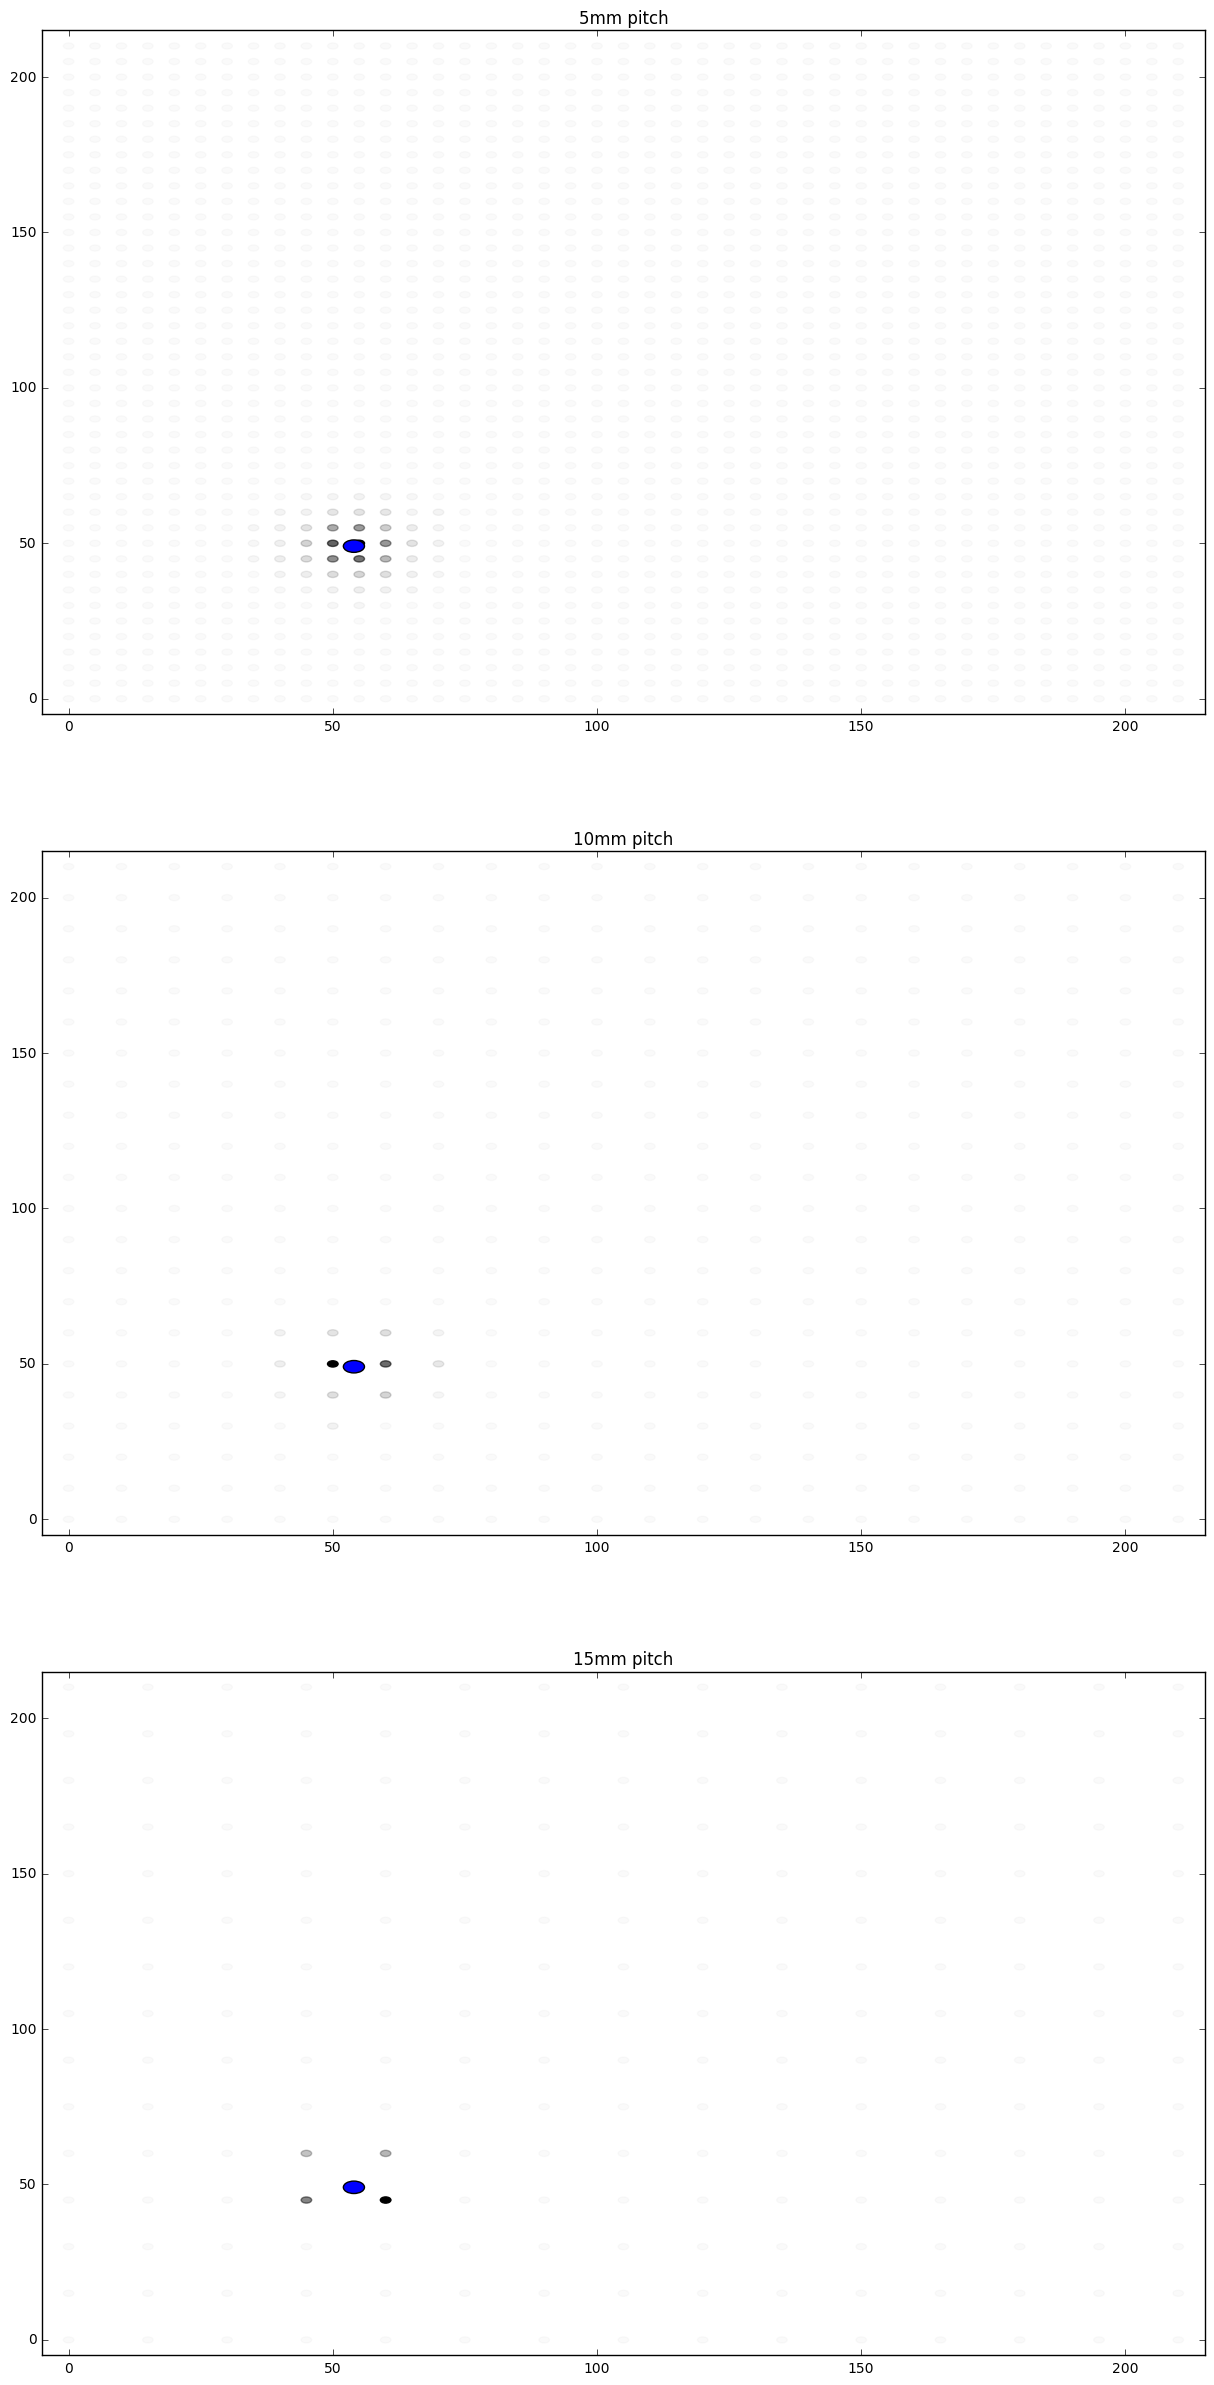

In [6]:
def SiPM_map_plot(xarr, yarr, pitch, size, plot_truth=True, normalize=True):
    """
    Plots a SiPM map in the NEW Geometry
    xarr is a NEW sipm map, yarr the pair of coordinates the map corresponds to
    """
    if normalize:
        probs = (xarr - np.min(xarr))
        probs /= np.max(probs)
    else: 
        probs = xarr

    for i in range(xarr.shape[0]):
        for j in range(xarr.shape[1]):
            #if probs[i,j] > 0.02: print(np.array([i,j])*10 - 235) 

            r = Ellipse(xy=(i * pitch, j * pitch), width=2., height=2.);
            r.set_facecolor('0');
            r.set_alpha(.02 + .98*probs[i, j]);
            ax1.add_artist(r);
            
    if plot_truth:
        # Place a large blue circle for actual EL points.
        xpt = yarr[0]
        ypt = yarr[1]
        mrk = Ellipse(xy=(xpt,ypt), width=4., height=4.);
        mrk.set_facecolor('b');
        ax1.add_artist(mrk);
        
    ax1.axis([-5, size + 5, -5, size + 5]);   
    
rev = np.random.randint(nevts)    
fig = plt.figure();
fig.set_figheight(30.0)
fig.set_figwidth(15.0)
ax1 = fig.add_subplot(311);
SiPM_map_plot(maps5[rev], hits[rev], 5, size)
plt.title('5mm pitch')
ax1 = fig.add_subplot(312);
SiPM_map_plot(maps10[rev], hits[rev], 10, size)
plt.title('10mm pitch')
ax1 = fig.add_subplot(313);
SiPM_map_plot(maps15[rev], hits[rev], 15, size)
plt.title('15mm pitch')
plt.show()

Save the data

In [7]:
f = tb.open_file('pitch_experiment/pitch_exp_100k.h', 'w')
filters = tb.Filters(complib='blosc', complevel=9, shuffle=False)

atom = tb.Atom.from_dtype(maps5.dtype)
smaps5 = f.create_earray(f.root, 'maps5', atom, (0, maps5.shape[1], maps5.shape[2]), filters=filters) 
smaps10 = f.create_earray(f.root, 'maps10', atom, (0, maps10.shape[1], maps10.shape[2]), filters=filters) 
smaps15 = f.create_earray(f.root, 'maps15', atom, (0, maps15.shape[1], maps15.shape[2]), filters=filters) 

atom = tb.Atom.from_dtype(hits.dtype)
tcoords = f.create_earray(f.root, 'coords', atom, (0, 2), filters=filters)

for i in range(nevts):
    smaps5.append([maps5[i]])
    smaps10.append([maps10[i]])
    smaps15.append([maps15[i]])
    tcoords.append([hits[i]])

print(f)
f.close()

pitch_experiment/pitch_exp_100k.h (File) ''
Last modif.: 'Tue Nov 22 18:30:10 2016'
Object Tree: 
/ (RootGroup) ''
/coords (EArray(100000, 2), blosc(9)) ''
/maps10 (EArray(100000, 22, 22), blosc(9)) ''
/maps15 (EArray(100000, 15, 15), blosc(9)) ''
/maps5 (EArray(100000, 43, 43), blosc(9)) ''

